In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from scipy import signal
from mne.time_frequency import psd_array_multitaper
import optuna
import optuna.visualization as vis
import os
from nolds import sampen

In [ ]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 80.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')
fs = 500  # Sampling rate
sampling_rate = 1666 ### simulacion 



In [ ]:
resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación del programa:")
    print(resultado_compilacion.stderr)


def Simulado_EGG(params,Normalizacion):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params

    # Ejecución del programa
    resultado_ejecucion_s= subprocess.run(f" OMP_NUM_THREADS=3 ./main {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion_s.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion_s.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion_s.stdout.strip().split('\n')

    data_list = [float(line) for line in lines]

    data = np.array(data_list)[50:]

    if(Normalizacion=="max_global"):    
        data=data/max(data)
    elif(Normalizacion=="zscore"):
        data=(data-np.mean(data))/np.std(data)

    n_samples_resampled = int(len(data)*(fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=60, adaptive=True,verbose=False,n_jobs=1)
    frequencies=np.array(frequencies)

    welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies > 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies > 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies > 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies > 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



In [76]:
def read_all_signals_from_folders(parent_folder):

    all_signals = []
    
    # Iterar sobre las subcarpetas en la carpeta principal
    for folder_name in sorted(os.listdir(parent_folder)):
        folder_path = os.path.join(parent_folder, folder_name)
        if os.path.isdir(folder_path):  # Asegurarse de que es una carpeta
            # Leer señales de la carpeta actual
            senal_uni, _ = read_signals(folder_path)
            all_signals.extend(senal_uni)  # Agregar todas las señales de esta carpeta
    
    # Concatenar todas las señales en un solo array
    all_signals_array = np.concatenate(all_signals)
    
    # Calcular valores globales
    global_min = np.min(all_signals_array)
    global_max = np.max(all_signals_array)
    global_mean = np.mean(all_signals_array)
    global_std = np.std(all_signals_array)
    
    return all_signals_array, global_min, global_max, global_mean, global_std

def read_signals(folder_path):
    signals = []
    file_names = []
    for file_name in sorted(os.listdir(folder_path)):  # Ordenar los archivos por nombre
        if file_name.endswith(".txt"):  # Filtrar solo archivos de texto
            file_path = os.path.join(folder_path, file_name)
            signal_i = np.loadtxt(file_path)  # Leer los datos del archivo
            signals.append(signal_i)
            file_names.append(file_name)  # Guardar el nombre del archivo
    return signals, file_names

def euclidean_distance(function1, function2):
    return np.sqrt(np.sum((np.array(function1) - np.array(function2))**2))

parent_folder = "Datos_reales"
all_signals_array, global_min, global_max, global_mean, global_std = read_all_signals_from_folders(parent_folder)

# Imprimir resultados
print("Número total de señales:", len(all_signals_array))
print("Mínimo global:", global_min)
print("Máximo global:", global_max)
print("Media global:", global_mean)
print("Desviación estándar global:", global_std)

Número total de señales: 32000
Mínimo global: -7.5019798015625e-05
Máximo global: 3.7541179509375e-05
Media global: -1.8103846518043457e-05
Desviación estándar global: 1.8481663638416723e-05


In [ ]:
def Datos_reales(directorio,Normalizacion, global_min, global_max, global_mean, global_std):
    Datos,nombres= read_signals(directorio)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.zeros((len(nombres), 2)) 
    Theta = np.zeros((len(nombres), 2)) 
    Alpha = np.zeros((len(nombres), 2)) 
    Beta = np.zeros((len(nombres), 2)) 
    if(Normalizacion=="max_global"):    
            Datos=Datos/global_max
    elif(Normalizacion=="zscore"):
        Datos=(Datos-global_mean) / global_std
    for i in range(len(Datos)):
        Butter[i]=butter= signal.filtfilt(b, a,Datos[i])
        psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=60, adaptive=True,verbose=False,n_jobs=1)
        Frequencies[i]=frequencies=np.array(frequencies)
        welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
        welch_datos[i]=welch_data
        delta = welch_data[np.logical_and(frequencies >= 0, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 3, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 14)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]
        Delta[i]=np.array([delta.mean(),delta.std()])
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]
    mean_welch=np.mean(welch_datos)
    mean_Delta=[Delta[:,0].mean(),np.mean(Delta[:,1])]
    mean_Theta=[Theta[:,0].mean(),np.mean(Theta[:,1])]
    mean_Alpha=[Alpha[:,0].mean(),np.mean(Alpha[:,1])]
    mean_Beta=[Beta[:,0].mean(),np.mean(Beta[:,1])]
    return {
        "Nombres":nombres,"Zona":directorio,
        'datos': Datos, "frequencies": Frequencies,  "welch_data":welch_datos,"mean_welch":mean_welch,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'mean_Delta': mean_Delta,'mean_Theta':mean_Theta,"mean_Alpha":mean_Alpha,"mean_Beta":mean_Beta
    }


In [ ]:
Params={'L': 13, 'P': 0.8669111464318684, 'Inh': 0.5045894829120994, 'Trest': 2.6877626216798536, 'Trelative': 3.091425108671755, 'C_h': 0.2832848820459372, 'Tipo_red': 4}
initial_params = [Params["L"], Params["P"],Params["Inh"], Params["Trest"],Params["Trelative"], Params["C_h"] ,6716, Params["Tipo_red"]]
Normalizacion="zscore"###"max_global""max_global_abs" zscore
generated_data= Simulado_EGG(initial_params,Normalizacion)
Zona="P"
reales_total = Datos_reales(f"Datos_reales/{Zona}",Normalizacion, global_min, global_max, global_mean, global_std)
print(reales_total["datos"])
print(len(reales_total["datos"][0]))
print(len(generated_data["data"]))
print(len(generated_data["data_resample"]))
print(len(generated_data["butter"]))

[[ 0.33154372  0.2695147   0.20748698 ...  0.19425968  0.09738768
  -0.00872026]
 [ 0.91564409  0.90965837  0.90361588 ...  1.31569179  1.28289931
   1.18962519]
 [ 0.13969283  0.16438911  0.17206219 ...  0.44435594  0.418865
   0.36247018]]
2000
6666
2000
2000


['P3_MNE.txt', 'P4_MNE.txt', 'Pz_MNE.txt']


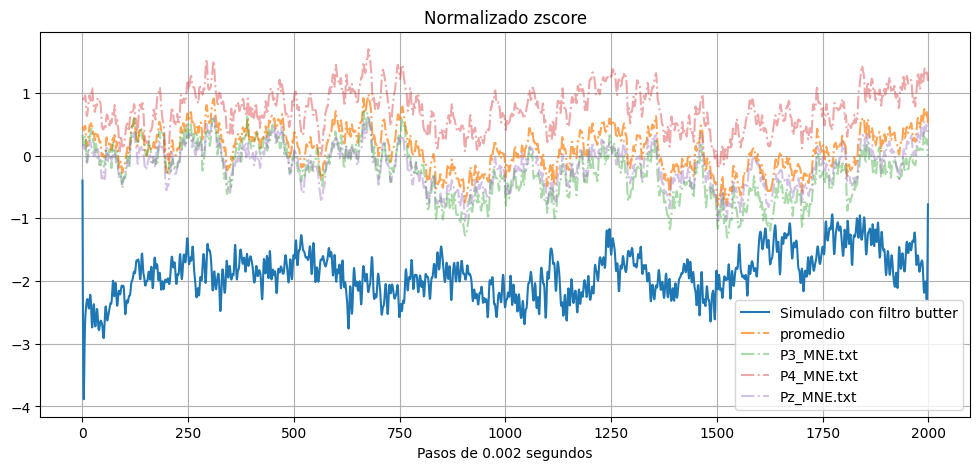

In [90]:
fig, ax = plt.subplots(figsize=[12, 5])
print(reales_total["Nombres"])
#ax.plot(generated_data["data_resample"],label="Simulado")

ax.plot(generated_data["butter"],label="Simulado con filtro butter")
grupos = np.array(reales_total["datos"])
promedio = np.mean(grupos, axis=0) 

ax.plot(promedio,"-.", label="promedio",alpha=0.7)

for i in range(len(reales_total["datos"])):
    ax.plot(reales_total["datos"][i],"-.", label=reales_total["Nombres"][i],alpha=0.4)


plt.xlabel("Pasos de 0.002 segundos")
#plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.title(f"Normalizado {Normalizacion}")
plt.show()  # Mostrar todos los gráficos en la misma figura


24.521073319827977
['P3_MNE.txt', 'P4_MNE.txt', 'Pz_MNE.txt']
Delta [np.float64(9.498465962489835), np.float64(3.2522691618527007)] ---- [np.float64(9.385823564384154), np.float64(3.4279460050324064)]
Theta [np.float64(1.7329469803175959), np.float64(2.053396821568523)] ---- [np.float64(3.515984039314157), np.float64(1.2956891302865412)]
Alpha [np.float64(-2.20210692454593), np.float64(2.0885000489538568)] ---- [np.float64(0.33285415546517116), np.float64(1.780579615851563)]
Beta [np.float64(-6.379448984287516), np.float64(1.4801737135274173)] ---- [np.float64(-6.762215687190261), np.float64(2.1448623639029054)]


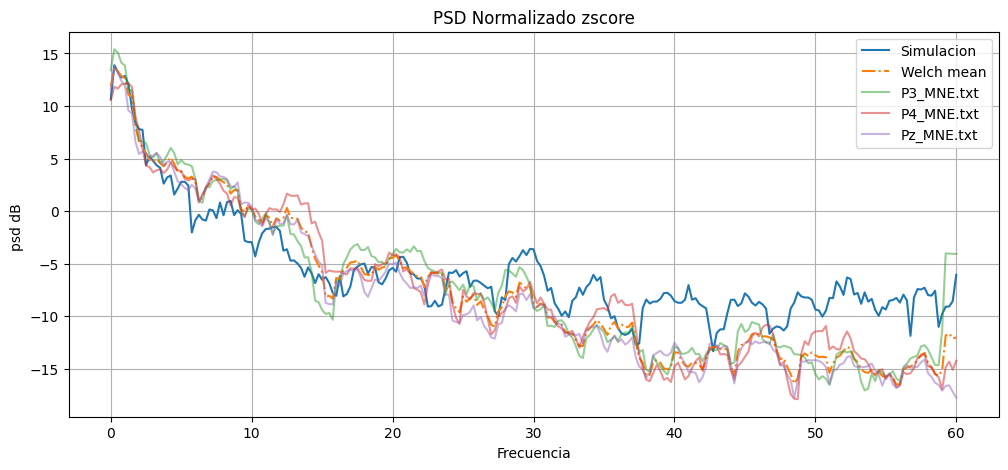

In [91]:
fig, ax = plt.subplots(figsize=[12, 5])

hi2_stat = euclidean_distance(generated_data["welch_data"][:121],reales_total["mean_welch"][:121])

print(abs(hi2_stat))
print(reales_total["Nombres"])
print("Delta",generated_data["delta"],"----",reales_total["mean_Delta"])
print("Theta",generated_data["theta"],"----",reales_total["mean_Theta"])
print("Alpha",generated_data["alpha"],"----",reales_total["mean_Alpha"])
print("Beta",generated_data["beta"],"----",reales_total["mean_Beta"])

ax.plot(generated_data["frequencies"],generated_data["welch_data"],label="Simulacion")
ax.plot(reales_total["frequencies"][0],reales_total["mean_welch"],label="Welch mean",linestyle="-.")
for i in range(len(reales_total["datos"])):
    ax.plot(reales_total["frequencies"][i],reales_total["welch_data"][i], label=reales_total["Nombres"][i],alpha=0.5)

plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
plt.grid()
plt.title(f"PSD Normalizado {Normalizacion}")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


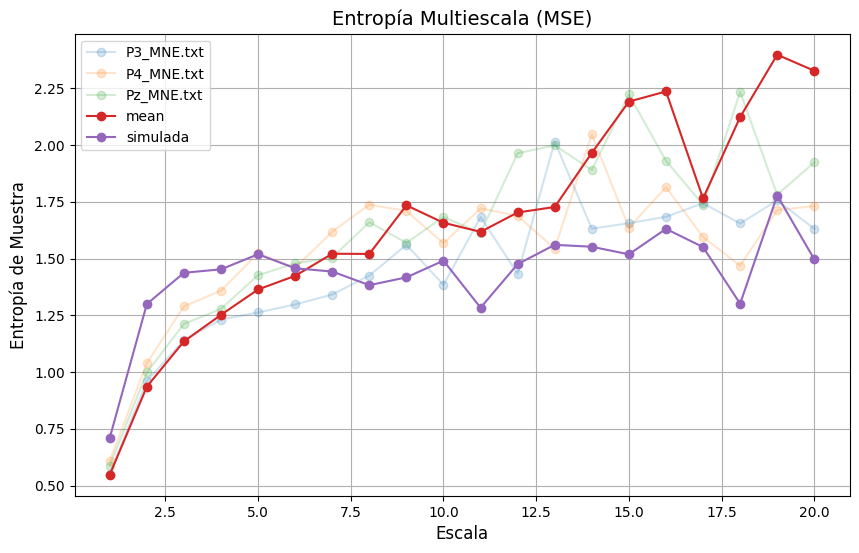

In [81]:
def coarse_grain(series, scale):
    length = len(series)
    coarse_grained = [
        np.mean(series[i * scale:(i + 1) * scale])
        for i in range(length // scale)
    ]
    return np.array(coarse_grained)

# Función para calcular MSE
def multiscale_entropy(series, max_scale, m=2, r=0.2):

    mse_values = []
    sd = np.std(series)  # Calcula la desviación estándar de la serie
    tolerance = r * sd  # Define la tolerancia
    
    for scale in range(1, max_scale + 1):
        coarse_grained_series = coarse_grain(series, scale)
        # Calcula SampEn para la serie granularizada
        entropy = sampen(coarse_grained_series, emb_dim=m, tolerance=tolerance)
        mse_values.append(entropy)
    
    return mse_values

# Datos de ejemplo

max_scale = 20
all_mse_results = []
plt.figure(figsize=(10, 6))
for i, señal in enumerate(reales_total["datos"]):
    mse_result = multiscale_entropy(señal, max_scale)
    all_mse_results.append(mse_result)
    plt.plot(range(1, max_scale + 1), mse_result, marker='o', label=reales_total["Nombres"][i],alpha=0.2)

mse_result_mean= multiscale_entropy(promedio, max_scale)
plt.plot(range(1, max_scale + 1), mse_result_mean, marker='o', label=f"mean")

mse_result_S= multiscale_entropy(generated_data["butter"], max_scale)
plt.plot(range(1, max_scale + 1), mse_result_S, marker='o', label=f"simulada")

plt.title(f"Entropía Multiescala (MSE)", fontsize=14)
plt.xlabel("Escala", fontsize=12)
plt.ylabel("Entropía de Muestra", fontsize=12)
plt.grid()
plt.legend()
plt.show()


In [92]:
Tipo_de_red="S"


def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',10,30)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0,5.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',0,4)

    generated= Simulado_EGG(params,Normalizacion)
    if generated["delta"][1]-generated["delta"][1]==0:
        hi2_stat=euclidean_distance(generated["welch_data"][:121],reales_total["mean_welch"][:121])
        trial.report(hi2_stat, step=trial.number)### general
        return hi2_stat
    else:
        return float('inf')  
    
# Create and optimize the study
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            #pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)


[I 2024-11-26 23:43:52,017] Using an existing study with name 'Chi30_S_zscore' instead of creating a new one.
[I 2024-11-26 23:43:52,703] Trial 500 finished with value: 826.0264586810424 and parameters: {'L': 23, 'P': 0.302463866648497, 'Inh': 0.6927260391651338, 'Trest': 0.25248805697896354, 'Trelative': 5.030321766281903, 'C_h': 0.47971030891992134, 'Tipo_red': 0}. Best is trial 427 with value: 32.258104775669786.
[I 2024-11-26 23:43:53,395] Trial 501 finished with value: 43.62545198257135 and parameters: {'L': 25, 'P': 0.3319887556617628, 'Inh': 0.7726169558187715, 'Trest': 0.3619691700838824, 'Trelative': 4.887699428124398, 'C_h': 0.7772137288443877, 'Tipo_red': 0}. Best is trial 427 with value: 32.258104775669786.
[I 2024-11-26 23:43:54,089] Trial 502 finished with value: 45.48306984933524 and parameters: {'L': 24, 'P': 0.26830735358155017, 'Inh': 0.5933557618946235, 'Trest': 0.43905063452137955, 'Trelative': 4.708733870092685, 'C_h': 0.7232274904399221, 'Tipo_red': 0}. Best is tr

KeyboardInterrupt: 

In [93]:

print(study.study_name)
valid_trials = [t for t in study.trials if t.value is not None]
top_3_trials = sorted(valid_trials, key=lambda t: t.value)[:10]
for i, trial in enumerate(top_3_trials):
    print(f"\nTrial {i+1}:")
    print("Params:", trial.params)
    print("Value:", trial.value)
print("---------------------------------------","\n")
print("Best Result:", study.best_value)

vis.plot_optimization_history(study)


Chi30_S_zscore

Trial 1:
Params: {'L': 23, 'P': 0.12124428716632385, 'Inh': 0.5971351158144563, 'Trest': 0.30532211574077917, 'Trelative': 4.475865589999594, 'C_h': 0.7903445458414067, 'Tipo_red': 0}
Value: 32.258104775669786

Trial 2:
Params: {'L': 25, 'P': 0.33855796071036903, 'Inh': 0.6675010487836166, 'Trest': 0.3598438933644831, 'Trelative': 4.884922263524363, 'C_h': 0.8027566535927181, 'Tipo_red': 0}
Value: 33.42358781399238

Trial 3:
Params: {'L': 25, 'P': 0.09038379365968983, 'Inh': 0.6342508926652558, 'Trest': 0.6453233269209938, 'Trelative': 4.384795427616911, 'C_h': 0.7495430710487795, 'Tipo_red': 0}
Value: 33.49367913853591

Trial 4:
Params: {'L': 24, 'P': 0.09647825066107871, 'Inh': 0.745859743874237, 'Trest': 0.7026164596001881, 'Trelative': 2.654303670838112, 'C_h': 0.7945550106441314, 'Tipo_red': 0}
Value: 34.71499550784422

Trial 5:
Params: {'L': 25, 'P': 0.3204946231612982, 'Inh': 0.7501592132603317, 'Trest': 0.5860664315217881, 'Trelative': 4.054097529288856, 'C_h': 

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, ..., 511, 512, 513],
              'y': [41.4746446701892, inf, inf, ..., 47.77988776431762,
                    44.910611408964726, 196.19118979884786]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, ..., 512, 513, 514],
              'y': [41.4746446701892, 41.4746446701892, 41.4746446701892, ...,
                    32.258104775669786, 32.258104775669786, 32.258104775669786]},
             {'marker': {'color': '#cccccc'},
              'mode': 'markers',
              'name': 'Infeasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [],
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Optimization History Plot'},
               'xaxis': {'title': {'text': 'Trial'}},
               'yaxis': {'title': {'text': 'Objective Value'}}}
})

In [ ]:
vis.plot_param_importances(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_slice(study)